**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np
import pickle

from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from imblearn.over_sampling import SMOTE

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred = y_test_pred.round()

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [7]:
DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

# input
TRAIN_PART_PATH = DATA_ROOT / 'train.csv'
TEST_PART_PATH = DATA_ROOT / 'test.csv'
# PREP_DATASET_PATH = DATA_ROOT / 'training_project_data_prep.csv'

# output
RESULT_PART_PATH = DATA_ROOT / 'sample_submission.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

**Загрузка данных**

In [8]:
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test  = pd.read_csv(TEST_PART_PATH)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Удаляем ошибочную строку**

In [9]:
idx = df_train[(df_train['Monthly Debt']==0) & (df_train['Current Credit Balance']==0) & (df_train['Credit Default']==1)].index
df_train = df_train.drop(idx)

In [10]:
df_train['Credit Default'] = df_train['Credit Default'].astype(int)

**Выделение признакового описания и целевой переменной**

In [11]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                      'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                      'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount',
                      'Current Credit Balance', 'Monthly Debt', 'Credit Score']

NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                      'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Purpose', 'Term']

**Исследуем признаки и заполяем пропуски**

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>],
       [<AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>],
       [<AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>, <AxesSubplot:>]],
      dtype=object)

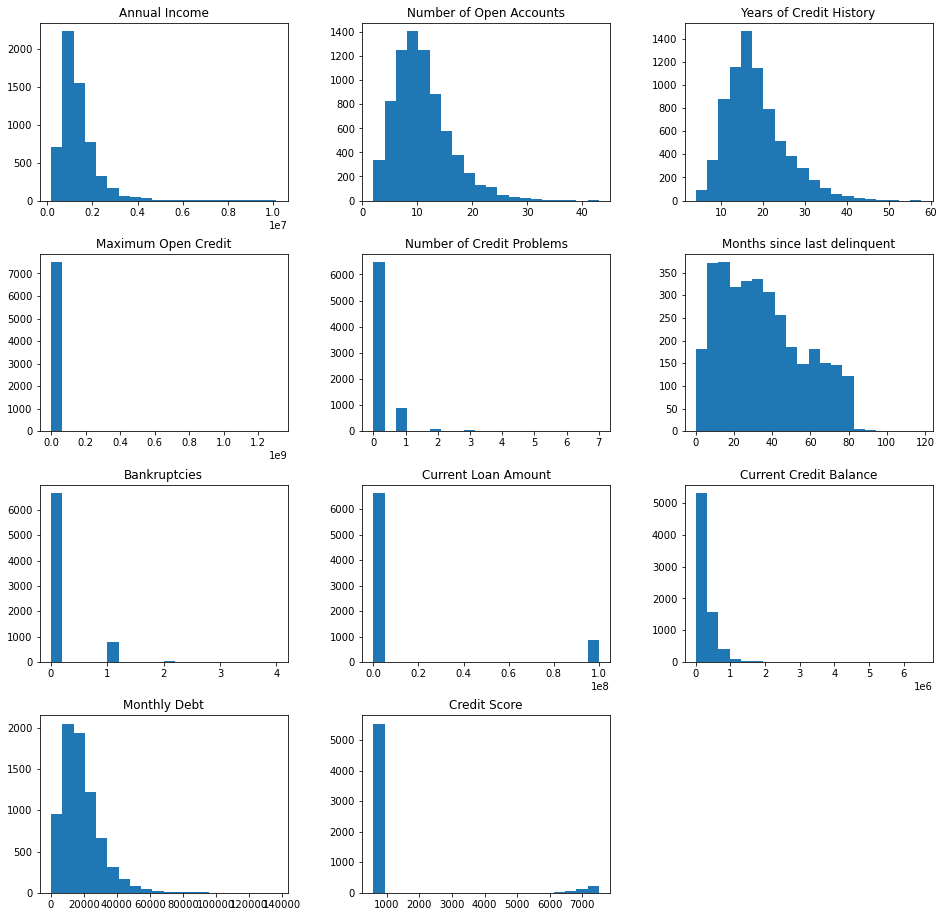

In [12]:
columns = NUM_FEATURE_NAMES
df_train[columns].hist(figsize=(16, 16), bins=20, grid=False)

In [13]:
def set_na(df, col, condition):
    df.loc[condition, col] = np.nan
    return df

In [14]:
def fill_on_group(df, col, group_col):
    df_group = df[~df[col].isna()].groupby(group_col, as_index=False).agg({col:'median'}).copy()
    new_col_name = col + '_1'
    df_group = df_group.rename(columns={col:new_col_name})
    
    df = df.merge(df_group, on=group_col, how='left')

    df.loc[df[col].isna(), col] = df.loc[df[col].isna(), new_col_name]    
    
    df = df.drop(new_col_name, axis=1)
    
    return df

In [15]:
def first_prepate_train(X):
    condition = (X['Months since last delinquent']==0) | (X['Months since last delinquent'].isna())
    X.loc[condition, 'Months since last delinquent'] = X.loc[condition, 'Years of Credit History'] * 12
    
    X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = 0
    
    condition = X['Credit Score'] > 1000
    X.loc[condition, 'Credit Score'] = X.loc[condition, 'Credit Score'] / 10
    
    X.loc[X['Tax Liens']> 6, 'Tax Liens'] = 7

    X['Tax Liens'] = X['Tax Liens'].astype(str)
    
    feature_name = 'Maximum Open Credit'
    condition = (X[feature_name] > 60000000) | (X[feature_name] == 0)
    X = set_na(X, feature_name, condition)
    
    feature_name = 'Current Loan Amount'
    condition = X[feature_name] >= 99999999
    X = set_na(X, feature_name, condition)
    
    feature_name = 'Years in current job'
    X.loc[X[feature_name].isna(), feature_name] = X[feature_name].mode()[0]
    
    feature_name = 'Annual Income'
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Years in current job'])
    idx = X[X[feature_name].isna()].index
    X = X.drop(idx, axis=0) 
    
    feature_name = 'Purpose'
    idx = X[X[feature_name] == 'renewable energy'].index
    X = X.drop(idx, axis=0) 
    
    feature_name = 'Maximum Open Credit'
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Years in current job'])
    
    condition = (~X['Current Loan Amount'].isna()) & (X['Maximum Open Credit'].isna())
    X.loc[condition, 'Maximum Open Credit'] = X.loc[condition, 'Current Loan Amount']
    
    feature_name = 'Current Loan Amount'
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Years in current job', 'Purpose', 'Term'])
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Purpose', 'Term'])
    X = fill_on_group(X, feature_name, ['Purpose', 'Term'])
    
    feature_name = 'Credit Score'
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Years in current job', 'Purpose', 'Term'])
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Years in current job', 'Purpose'])
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Purpose', 'Term'])
    X = fill_on_group(X, feature_name, ['Home Ownership', 'Years in current job'])
    X = fill_on_group(X, feature_name, ['Purpose', 'Term'])
    
    
    return X

In [16]:
df_train = first_prepate_train(df_train)
df_test  = first_prepate_train(df_test)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7496 entries, 0 to 7495
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7496 non-null   object 
 1   Annual Income                 7496 non-null   float64
 2   Years in current job          7496 non-null   object 
 3   Tax Liens                     7496 non-null   object 
 4   Number of Open Accounts       7496 non-null   float64
 5   Years of Credit History       7496 non-null   float64
 6   Maximum Open Credit           7496 non-null   float64
 7   Number of Credit Problems     7496 non-null   float64
 8   Months since last delinquent  7496 non-null   float64
 9   Bankruptcies                  7496 non-null   float64
 10  Purpose                       7496 non-null   object 
 11  Term                          7496 non-null   object 
 12  Current Loan Amount           7496 non-null   float64
 13  Cur

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>],
       [<AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>],
       [<AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>, <AxesSubplot:>]],
      dtype=object)

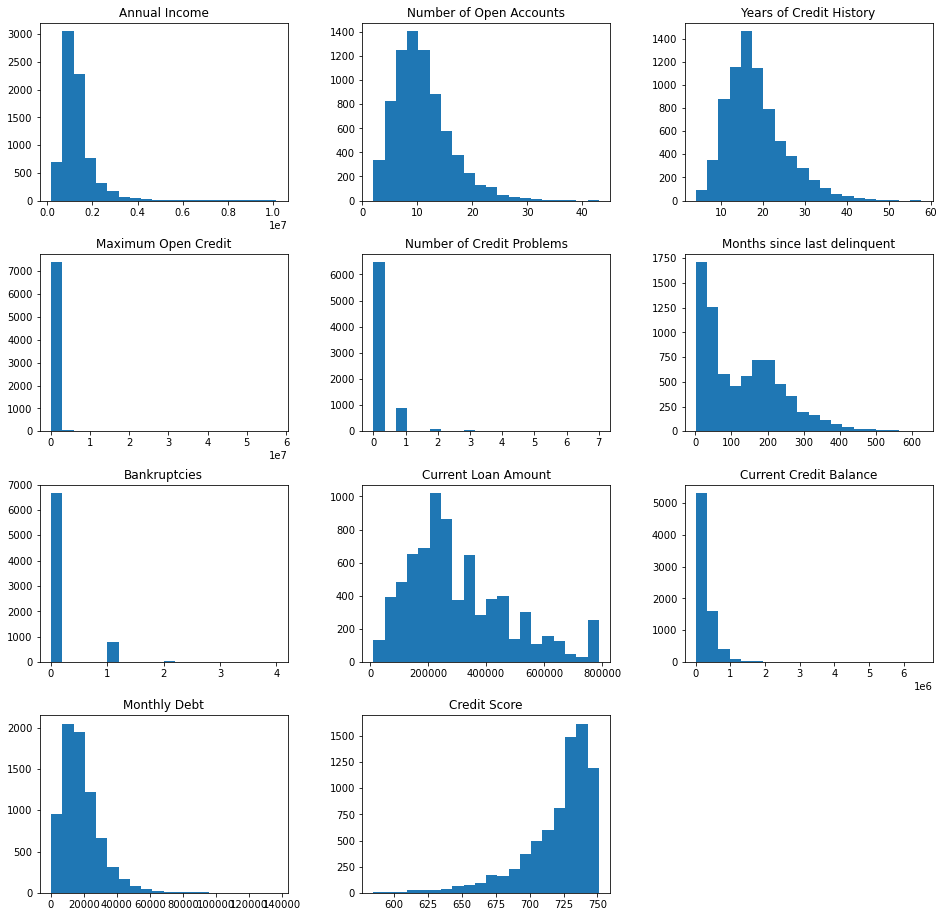

In [18]:
columns = NUM_FEATURE_NAMES
df_train[columns].hist(figsize=(16, 16), bins=20, grid=False)

In [19]:
df_train.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.496000e+03,7496.000000,7496.000000,7.496000e+03,7496.000000,7496.000000,7496.000000,7496.000000,7.496000e+03,7496.000000,7496.000000,7496.000000
mean,1.327215e+06,11.133404,18.317263,6.897887e+05,0.170091,130.242930,0.116996,303390.117329,2.899275e+05,18318.604189,721.421925,0.281483
std,7.617853e+05,4.907967,7.041973,1.262322e+06,0.498715,107.615943,0.346986,174767.212991,3.179232e+05,11926.563477,25.941541,0.449753
min,1.645970e+05,2.000000,4.000000,4.334000e+03,0.000000,1.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,8.939500e+05,8.000000,13.500000,2.867040e+05,0.000000,35.000000,0.000000,177650.000000,1.143088e+05,10072.500000,711.000000,0.000000
50%,1.162325e+06,10.000000,17.000000,4.849240e+05,0.000000,112.800000,0.000000,264374.000000,2.093705e+05,16080.000000,731.000000,0.000000
75%,1.500164e+06,14.000000,21.800000,7.933310e+05,0.000000,202.800000,0.000000,407635.250000,3.604585e+05,23818.000000,739.000000,1.000000
max,1.014934e+07,43.000000,57.700000,5.756256e+07,7.000000,626.400000,4.000000,789030.000000,6.506797e+06,136679.000000,751.000000,1.000000


In [20]:
def trans_num(data):
    
    data = data.copy()
    
    select_columns = data.select_dtypes(include='object').columns

    for cat_colname in select_columns:
        data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)        
    
    features = data.select_dtypes(include=['float64', 'float32', 'float16', 'uint8']).columns
    
    data = data[features]
    
    return data
    
    

In [21]:
X = df_train.drop(columns=TARGET_NAME)
y = df_train[TARGET_NAME]

In [22]:
X_num = trans_num(X)
X_df_test = trans_num(df_test)


In [23]:
df_for_fit = pd.concat([X_num, X_df_test], axis=0).copy()

feature_names_for_stand = df_for_fit.columns


scaler = StandardScaler()
scaler.fit(df_for_fit)

stand_features = scaler.transform(X_num)
X_num = pd.DataFrame(stand_features, columns=feature_names_for_stand)

stand_features = scaler.transform(X_df_test)
X_df_test = pd.DataFrame(stand_features, columns=feature_names_for_stand)

X_df_test.info()
X_df_test.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Number of Open Accounts         2500 non-null   float64
 2   Years of Credit History         2500 non-null   float64
 3   Maximum Open Credit             2500 non-null   float64
 4   Number of Credit Problems       2500 non-null   float64
 5   Months since last delinquent    2500 non-null   float64
 6   Bankruptcies                    2500 non-null   float64
 7   Current Loan Amount             2500 non-null   float64
 8   Current Credit Balance          2500 non-null   float64
 9   Monthly Debt                    2500 non-null   float64
 10  Credit Score                    2500 non-null   float64
 11  Home Ownership_Have Mortgage    2500 non-null   float64
 12  Home Ownership_Home Mortgage    25

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-0.348558,-0.438548,-0.820210,-0.357203,-0.326562,-0.555531,-0.327448,-0.811811,-0.555767,-0.971508,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
1,-1.408524,-1.051570,2.026848,-0.481389,-0.326562,-1.128850,-0.327448,-1.293033,-0.735002,-1.351446,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
2,-0.225407,-0.234207,-0.651078,-0.369521,-0.326562,0.317393,-0.327448,-0.596230,-0.434266,0.035688,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
3,-0.138318,0.991838,-0.185965,-0.180105,-0.326562,-0.555531,-0.327448,-0.497873,-0.234553,0.782040,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
4,1.301722,-0.029866,0.744262,0.385029,-0.326562,1.415946,-0.327448,2.705154,0.400706,2.053798,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,1.694526,-1.694526


In [24]:
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7496 entries, 0 to 7495
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   7496 non-null   float64
 1   Number of Open Accounts         7496 non-null   float64
 2   Years of Credit History         7496 non-null   float64
 3   Maximum Open Credit             7496 non-null   float64
 4   Number of Credit Problems       7496 non-null   float64
 5   Months since last delinquent    7496 non-null   float64
 6   Bankruptcies                    7496 non-null   float64
 7   Current Loan Amount             7496 non-null   float64
 8   Current Credit Balance          7496 non-null   float64
 9   Monthly Debt                    7496 non-null   float64
 10  Credit Score                    7496 non-null   float64
 11  Home Ownership_Have Mortgage    7496 non-null   float64
 12  Home Ownership_Home Mortgage    74

In [25]:
X_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Number of Open Accounts         2500 non-null   float64
 2   Years of Credit History         2500 non-null   float64
 3   Maximum Open Credit             2500 non-null   float64
 4   Number of Credit Problems       2500 non-null   float64
 5   Months since last delinquent    2500 non-null   float64
 6   Bankruptcies                    2500 non-null   float64
 7   Current Loan Amount             2500 non-null   float64
 8   Current Credit Balance          2500 non-null   float64
 9   Monthly Debt                    2500 non-null   float64
 10  Credit Score                    2500 non-null   float64
 11  Home Ownership_Have Mortgage    2500 non-null   float64
 12  Home Ownership_Home Mortgage    25

In [26]:
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_num, y,
                                                                    test_size=0.25,
                                                                    shuffle=True,
                                                                    random_state=32)

In [27]:
df_num_train_bal = pd.concat([X_num_train, y_num_train], axis=1)

In [28]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=32)
        
        X_train_smote = df.drop(columns=target_name)
        y_train_smote = df[target_name].ravel()
        
        #X_smote, y_smote = smote.fit_sample(X_train_smote, y_train_smote.ravel())
        #y_smote = smote.fit(X_train_smote, y_train_smote.ravel())
        smote.fit(X_train_smote, y_train_smote.ravel())

        X_smote, y_smote = smote.fit_resample(X_train_smote, y_train_smote)
        
        y_smote = pd.DataFrame(data=y_smote, columns=[target_name])

        #X_smote, y_smote = smote.fit(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [29]:
df_num_train_bal = balance_df_by_target(df_num_train_bal, TARGET_NAME, 'smote')
df_num_train_bal[TARGET_NAME].value_counts()

1    4050
0    4050
Name: Credit Default, dtype: int64

In [30]:
X_num_train_balanced = df_num_train_bal.drop(columns=TARGET_NAME)
y_num_train_balanced = df_num_train_bal[TARGET_NAME]

In [31]:
model_rfr = RandomForestRegressor(n_estimators=100,
                                  max_depth=6,
                                  min_samples_leaf = 20,
                                  random_state=32,
                                  verbose=1)
model_rfr.fit(X_num_train_balanced, y_num_train_balanced)

y_train_pred = model_rfr.predict(X_num_train_balanced)
y_test_pred = model_rfr.predict(X_num_test)

y_train_pred = y_train_pred.round()
y_test_pred  = y_test_pred.round()

get_classification_report(y_num_train_balanced, y_train_pred, y_num_test, y_test_pred)

df_train_pred = pd.DataFrame(data=y_test_pred, columns=[TARGET_NAME])
df_train_pred[TARGET_NAME].value_counts()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


TRAIN

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      4050
           1       0.68      0.73      0.70      4050

    accuracy                           0.70      8100
   macro avg       0.70      0.70      0.70      8100
weighted avg       0.70      0.70      0.70      8100

TEST

              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1336
           1       0.39      0.59      0.47       538

    accuracy                           0.62      1874
   macro avg       0.59      0.61      0.59      1874
weighted avg       0.68      0.62      0.64      1874

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               843  493
1               220  318


0.0    1063
1.0     811
Name: Credit Default, dtype: int64

In [32]:
X_df_test

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-0.348558,-0.438548,-0.820210,-0.357203,-0.326562,-0.555531,-0.327448,-0.811811,-0.555767,-0.971508,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
1,-1.408524,-1.051570,2.026848,-0.481389,-0.326562,-1.128850,-0.327448,-1.293033,-0.735002,-1.351446,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
2,-0.225407,-0.234207,-0.651078,-0.369521,-0.326562,0.317393,-0.327448,-0.596230,-0.434266,0.035688,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
3,-0.138318,0.991838,-0.185965,-0.180105,-0.326562,-0.555531,-0.327448,-0.497873,-0.234553,0.782040,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
4,1.301722,-0.029866,0.744262,0.385029,-0.326562,1.415946,-0.327448,2.705154,0.400706,2.053798,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,1.694526,-1.694526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-0.395655,0.583156,1.519451,-0.102707,1.616484,-0.574025,2.533712,-0.068094,-0.385632,-0.275617,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
2496,-0.053597,0.787497,-0.185965,0.784256,-0.326562,-0.490802,-0.327448,0.937867,3.436051,1.241601,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
2497,-0.200650,7.530745,-0.777927,0.760664,-0.326562,0.217525,-0.327448,0.720525,1.152290,1.572599,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136
2498,-0.776705,0.583156,1.477168,0.188246,-0.326562,1.992964,-0.327448,-0.266947,0.298489,-0.405785,...,-0.070186,-0.099504,-0.034669,-0.315322,-0.055775,-0.070902,-0.033191,-0.041274,-0.590136,0.590136


In [33]:
sample_submission = model_rfr.predict(X_df_test)
sample_submission = sample_submission.round()
df_sample_submission = pd.DataFrame(data=sample_submission, columns=[TARGET_NAME])
df_sample_submission[TARGET_NAME] = df_sample_submission[TARGET_NAME].astype(int)
df_sample_submission['Id'] = df_sample_submission.index
df_sample_submission = df_sample_submission.set_index('Id')
df_sample_submission.to_csv(RESULT_PART_PATH, index=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
